# Mongolia's Economic Stratification

This notebook will seek to understand how income stratification has changed over time. At the core of this idea is the question, have Mongolians gotten richer since 2010?

Link to data sources used in this notebook: 

- Monetary Income Grouping - [1212.mn](http://www.1212.mn/tables.aspx?tbl_id=DT_NSO_1900_032V1&Location_select_all=1&LocationSingleSelect=&Revenue_select_all=1&RevenueSingleSelect=&YearY_select_all=1&YearYSingleSelect=&viewtype=table)
    - Gives the percent of Mongolian households making within specific income buckets
- Inflation Rate - [1212.mn](http://www.1212.mn/tables.aspx?tbl_id=DT_NSO_0600_013V1&RATIO_select_all=1&RATIOSingleSelect=&YearY_select_all=1&YearYSingleSelect=&viewtype=linechart)
    - The annual average CPI inflation
- Monthly Average Wages - [1212.mn](http://www.1212.mn/tables.aspx?tbl_id=DT_NSO_0400_021V1&SOUM_select_all=0&SOUMSingleSelect=_0&Gender_select_all=0&GenderSingleSelect=_1&YearQ_select_all=0&YearQSingleSelect=&YearY_select_all=1&YearYSingleSelect=&viewtype=linechart)
    - Monthly average wages (not median!)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

In [2]:
plt.style.use('mds.mplstyle')

## Importing Data and Cleaning

In [3]:
income_groups = pd.read_csv('data/DT_NSO_1900_032V1_-_2021-12-15_-_www.1212.mn.csv')
inflation = pd.read_csv('data/DT_NSO_0600_013V1_-_2021-12-15_-_www.1212.mn.csv')
wages = pd.read_csv('data/DT_NSO_0400_021V1_-_2021-12-15_-_www.1212.mn.csv', thousands=',')

In [4]:
income_groups.head()

,Location,Revenue,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,National average,under 300 000,34.7,24.8,14.9,11.2,12.4,13.9,12.8,8.9,4.7,3.9
1,National average,300 001 - 500 000,24.7,20.8,17.6,16.8,16.6,18.1,16.5,14.2,12.5,10.5
2,National average,500 001 - 700 000,16.1,16.2,18.1,17.0,17.0,18.5,17.7,15.0,13.3,10.4
3,National average,700 001 - 900 000,9.6,12.2,14.3,14.3,14.0,14.3,14.3,13.7,13.8,11.8
4,National average,900 001 - 1 100 000,5.8,8.5,10.6,11.0,11.1,10.7,10.4,11.7,11.3,11.3


In [5]:
inflation.head()

,INDICATOR,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Inflation rate,52.7,325.5,183,66.3,53.1,44.6,20.5,6,10,...,8.9,14,12.5,10.4,1.9,1.3,6.4,8.1,5.2,2.3


In [6]:
wages.head()

,Aimag,Sex,1995,1996,1997,1998,1999,2000,2001,2002,...,2010,2011,2012,2014,2015,2016,2017,2018,2019,2020
0,Total,Total,24.4,31.9,37.8,48.1,55.4,62.3,65.2,71.3,...,341.5,424.2,557.6,796.6,808.0,861.9,944.5,1002.9,1124.3,1220.6


### Reformat from short form to long form

In [7]:
inflation = pd.melt(inflation, id_vars=['INDICATOR'], var_name='year', value_name='inflation').drop(columns='INDICATOR')

In [8]:
inflation['year'] = inflation['year'].astype('int')

In [9]:
inflation.head(2)

,year,inflation
0,1991,52.7
1,1992,325.5


In [10]:
income_groups = (pd.melt(income_groups, 
                         id_vars=['Location','Revenue'], 
                         var_name='year', 
                         value_name='percent')
                .rename(columns={'Location':'type','Revenue':'income_category'}))

In [11]:
income_groups['year'] = income_groups['year'].astype('int')

In [12]:
income_groups.head(2)

,type,income_category,year,percent
0,National average,under 300 000,2011,34.7
1,National average,300 001 - 500 000,2011,24.7


In [13]:
wages = pd.melt(wages, id_vars=['Aimag', 'Sex'], var_name='year', value_name='avg_wage')

In [14]:
wages = wages.drop(columns=['Aimag','Sex'])

In [15]:
wages['year'] = wages['year'].astype('int')

In [16]:
wages['avg_wage'] = wages['avg_wage'].astype('float')

In [17]:
wages.head(2)

,year,avg_wage
0,1995,24.4
1,1996,31.9


## Plot Economic Stratification from 2011-2020

Starting in 2019 the income group "2 100 001 and over" was split up to relfect the growing number of Mongolians making higher wages. If was split into "2 100 001 - 3 000 000" and "2 100 001 - 3 000 000". However this causes a problem for our analysis as we don't have consistent buckets from 2011 to 2020. 

To fix this we will take the percents from the two top buckets and add them together to recreate the "2 100 001 and over" bucket from pre-2019.  

For our analysis we only care about 2011 and 2020 and the national average.

In [18]:
income_groups = income_groups[(income_groups['year'] == 2011) | (income_groups['year'] == 2020)]
income_groups = income_groups[income_groups['type'] == 'National average']

These labels are ugly. Let's fix them

In [19]:
cat_mapper = {'under 300 000': '0-300,000', '300 001 - 500 000': '300,001-500,000', 
              '500 001 - 700 000':'500,001-700,000', '700 001 - 900 000': '700,001-900,000', 
              '900 001 - 1 100 000':'900,001-1,100,000', '1 100 001 - 1 600 000':'1,100,001-1,600,000', 
              '1 600 001 - 2 100 000':'1,600,001-2,100,000','2 100 001 and over': '2,100,001+', 
              '2 100 001 - 3 000 000':'2,100,001+', '3 000 001 and over':'2,100,001+'}

In [20]:
income_groups['income_category'] = income_groups['income_category'].replace(cat_mapper)

In [21]:
income_groups['income_category'].unique()

array(['0-300,000', '300,001-500,000', '500,001-700,000',
       '700,001-900,000', '900,001-1,100,000', '1,100,001-1,600,000',
       '1,600,001-2,100,000', '2,100,001+'], dtype=object)

In [22]:
income_groups = income_groups.groupby(by=['year','income_category']).sum().reset_index()

In [23]:
income_groups['bucket_min'] = income_groups['income_category'].str.split('-').str.get(0).str.split('+').str.get(0).str.replace(',','').astype('int')

In [24]:
income_groups = income_groups.sort_values(by=['year','bucket_min'])

In [25]:
income_groups

,year,income_category,percent,bucket_min
0,2011,"0-300,000",34.7,0
4,2011,"300,001-500,000",24.7,300001
5,2011,"500,001-700,000",16.1,500001
6,2011,"700,001-900,000",9.6,700001
7,2011,"900,001-1,100,000",5.8,900001
1,2011,"1,100,001-1,600,000",5.8,1100001
2,2011,"1,600,001-2,100,000",1.8,1600001
3,2011,"2,100,001+",1.5,2100001
8,2020,"0-300,000",3.9,0
12,2020,"300,001-500,000",10.5,300001


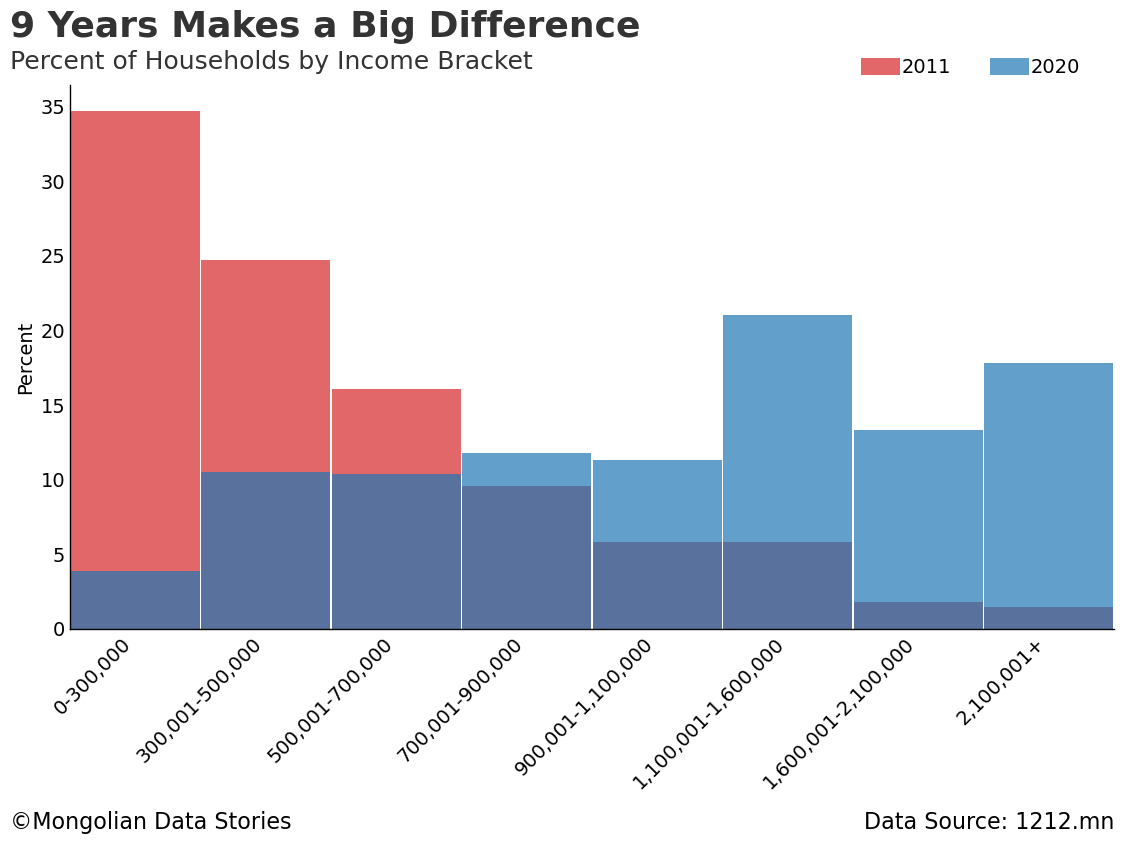

In [26]:
fig, ax = plt.subplots()

x1 = income_groups[income_groups['year'] == 2011]['income_category']
y1 = income_groups[income_groups['year'] == 2011]['percent']
y2 = income_groups[income_groups['year'] == 2020]['percent']

ax.bar(x1, y1, width=.99, alpha=.7, color='tab:red')
ax.bar(x1, y2, width=.99, alpha=.7, color='tab:blue')

# Format axes
ax.set_xlim(-0.5, 7.5)
ax.set_ylabel("Percent")

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Set Legend
ax.legend(['2011', '2020'], loc=(.75,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=0.03, y=.94, s="9 Years Makes a Big Difference", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.03, y=.90, s="Percent of Households by Income Bracket", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.03, y = -0.05, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = -0.05, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/2011v2020.png', dpi = 300, bbox_inches="tight")

## But what about inflation?

Like many developing countries, inflation can be a big issue in Mongolia. Let's factor in inflation to our monthly average wage number. To do this we need to create an "index value". We will set 2011 to 100 as this is our starting number (we could imagine this as 100 tugriks). From there we will see how this amount would be adjusted until 2020.

In [27]:
inflation = inflation[inflation['year'] >= 2011].reset_index(drop=True)

To create our index we loop through the rows and multiply the previous row by the current inflation.

In [28]:
index = []
for i, row in inflation.iterrows():
    if len(index) == 0:
        index.append(100)
    else:
        index.append(index[-1] * (row['inflation'] / 100 + 1))

In [29]:
inflation['inflation_index'] = pd.Series(index)

In [30]:
inflation

,year,inflation,inflation_index
0,2011,8.9,100.000000
1,2012,14.0,114.000000
2,2013,12.5,128.250000
3,2014,10.4,141.588000
4,2015,1.9,144.278172
5,2016,1.3,146.153788
6,2017,6.4,155.507631
7,2018,8.1,168.103749
8,2019,5.2,176.845144
9,2020,2.3,180.912582


Now we can merge this with the average wage data.

In [31]:
inflation = inflation.merge(wages, on='year', how='left')

We are missing data for 2013. We will take the average of 2012 and 2014 and impute that for 2013. 

In [32]:
inflation.loc[2, 'avg_wage'] = inflation.iloc[1:4]['avg_wage'].mean()

In [33]:
inflation.head()

,year,inflation,inflation_index,avg_wage
0,2011,8.9,100.000000,424.2
1,2012,14.0,114.000000,557.6
2,2013,12.5,128.250000,677.1
3,2014,10.4,141.588000,796.6
4,2015,1.9,144.278172,808.0


Now that we have our data together, we can rebalance the average wage column to put it into "2011" Tugriks. We will use a simple inflation adjustment calculation to do this.

In [34]:
inflation['inflation_adj'] = inflation['avg_wage'] / inflation['inflation_index'] * 100

In [35]:
inflation

,year,inflation,inflation_index,avg_wage,inflation_adj
0,2011,8.9,100.000000,424.2,424.200000
1,2012,14.0,114.000000,557.6,489.122807
2,2013,12.5,128.250000,677.1,527.953216
3,2014,10.4,141.588000,796.6,562.618301
4,2015,1.9,144.278172,808.0,560.029275
5,2016,1.3,146.153788,861.9,589.721286
6,2017,6.4,155.507631,944.5,607.365694
7,2018,8.1,168.103749,1002.9,596.595857
8,2019,5.2,176.845144,1124.3,635.753958
9,2020,2.3,180.912582,1220.6,674.690498


This function remakes our currency values to have the K and M suffix (K for thousands and M for millions). [Adapted from Jie Jenn](https://www.youtube.com/watch?v=l-j9Mmi7VPk).

In [36]:
def format_number(data_value, indx):
    if data_value >= 1_000:
        formatter = '{:1.1f}M'.format(data_value*0.001)
    else:
        formatter = '{:1.0f}K'.format(data_value)
    return formatter

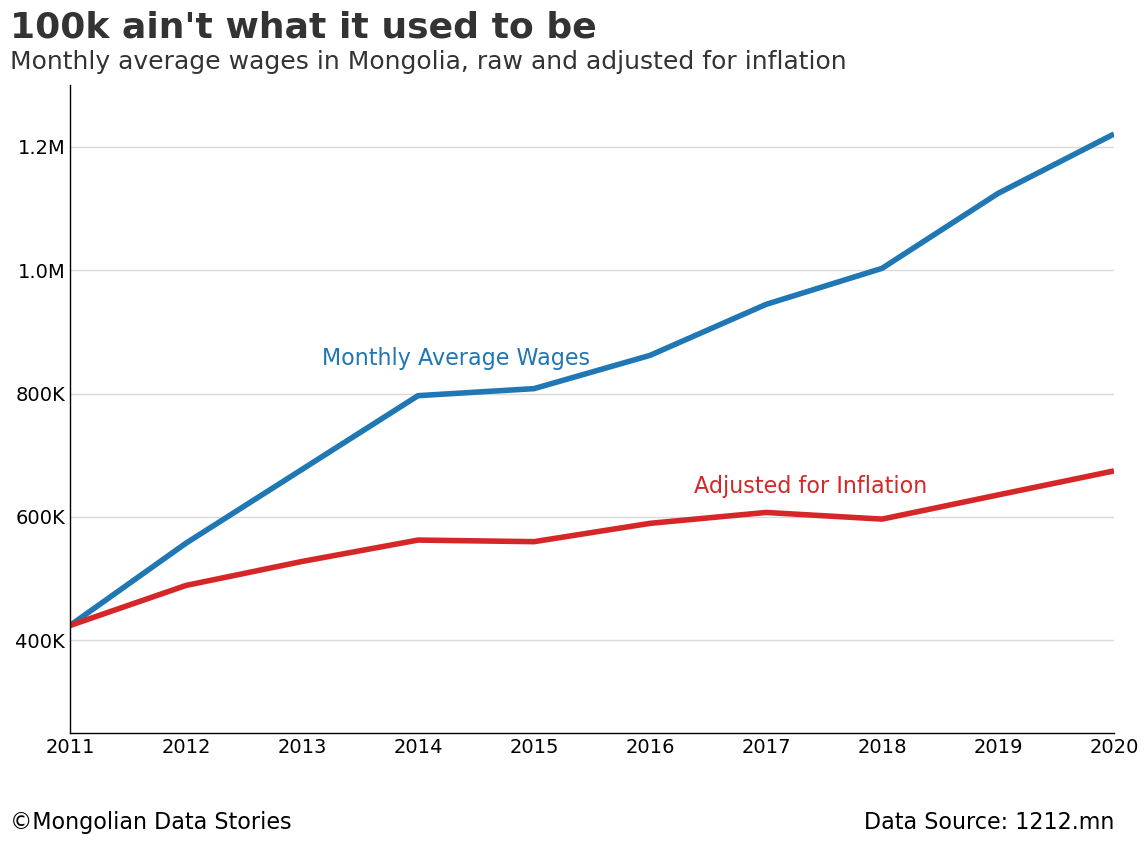

In [37]:
fig, ax = plt.subplots()

ax.plot(inflation['year'], inflation['avg_wage'], color='tab:blue')
ax.plot(inflation['year'], inflation['inflation_adj'], color='tab:red')

ax.set_ylim(250,1_300)
ax.set_xlim(2011, 2020)

# Add grid
ax.grid(axis='y', alpha=.7)

# Relabel y-axis to give pretty numbers
ax.yaxis.set_major_formatter(format_number)

# Add labels
ax.text(x = .29, y=.53, s='Monthly Average Wages', transform=fig.transFigure, fontsize = 16, color='tab:blue')
ax.text(x = .6, y=.37, s='Adjusted for Inflation', transform=fig.transFigure, fontsize = 16, color='tab:red')

# Set title and subtitle
ax.text(x=0.03, y=.94, s="100k ain't what it used to be", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.03, y=.90, s="Monthly average wages in Mongolia, raw and adjusted for inflation", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.03, y = -0.05, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = -0.05, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/inflation_adjusted_wages.png', dpi = 300, bbox_inches="tight")

## Realigning our thoughts on wages.

Given that we know that 300,000 in 2011 was worth quite a lot more today, let's realign our income distribution plot above to be in 2011 tugriks.

In [38]:
inflation

,year,inflation,inflation_index,avg_wage,inflation_adj
0,2011,8.9,100.000000,424.2,424.200000
1,2012,14.0,114.000000,557.6,489.122807
2,2013,12.5,128.250000,677.1,527.953216
3,2014,10.4,141.588000,796.6,562.618301
4,2015,1.9,144.278172,808.0,560.029275
5,2016,1.3,146.153788,861.9,589.721286
6,2017,6.4,155.507631,944.5,607.365694
7,2018,8.1,168.103749,1002.9,596.595857
8,2019,5.2,176.845144,1124.3,635.753958
9,2020,2.3,180.912582,1220.6,674.690498


In [39]:
index_2011 = inflation.iloc[0]['inflation_index']
index_2020 = inflation.iloc[9]['inflation_index']

In [40]:
300_000 / (index_2020/index_2011)

165825.94569574425

In [41]:
1_000_001 / (index_2020/index_2011)

552753.7050722998

In [42]:
1_600_000 / (index_2020/index_2011)

884405.0437106359